# Band-Limited Angular Spectrum Method for Numerical Simulation of Free-Space Propagation in Far and Near Fields

In [18]:
import numpy as np
import math
import cmath
import matplotlib.pyplot as plt

## the implementation of AS method and numerical integration

In [19]:
freq = np.fft.fftfreq(1024, 2)
print(freq)
freq = np.fft.fftshift(freq)
print(freq)

wave_length=1
n_S=50
band_limit=-1
wave_length = wave_length  # the length Fof the wave
dx = 2 * wave_length  # the sampling interval
N = 1024  #  the number of samplings
S = 2048 * wave_length  # the size of the sampling window
z = n_S * S  # the propagation distance

d_u = 1/(2*S)
print(d_u)



[ 0.          0.00048828  0.00097656 ... -0.00146484 -0.00097656
 -0.00048828]
[-0.25       -0.24951172 -0.24902344 ...  0.24853516  0.24902344
  0.24951172]
0.000244140625


In [20]:
def AS(wave_length=1, n_S=50, band_limit=-1):
    wave_length = wave_length  # the length Fof the wave
    dx = 2 * wave_length  # the sampling interval
    N = 1024  #  the number of samplings
    S = 2048 * wave_length  # the size of the sampling window
    z = n_S * S  # the propagation distance

    freq = np.fft.fftfreq(N, dx)
    freq_square = freq**2
    freq_squre_max = np.full(N, 1 / wave_length) ** 2
    w_square_0 = freq_squre_max - freq_square
    mask = w_square_0 > 0
    w_square = np.where(mask, w_square_0, 0)

    # the transfer function
    H_FR = np.empty(N, dtype=complex)
    H_FR = np.exp(2j * math.pi * z * np.sqrt(w_square))
    # H_FR = np.exp(1j * math.pi * z * (2 / wave_length - wave_length * (freq_square)))

    # generate the source plain spectrum
    g_0 = np.zeros(N)
    g_0[int(N / 4) : int(N / 4 * 3)] = np.ones(int(N / 2))

    G_0 = np.fft.fft(g_0)

    # the dest plain spectrum
    G_z = G_0 * H_FR

    if band_limit == -1:
        pass
    else:
        # limit the bandwidth
        G_z = np.fft.fftshift(G_z)
        f = band_limit
        G_z[0 : 512 + 1 - f] = np.zeros(513 - f)
        G_z[512 + f : 1024] = np.zeros(512 - f)
        G_z = np.fft.ifftshift(G_z)

    # the dest plain
    g_z = abs(np.fft.ifft(G_z))

    return H_FR.real, g_z

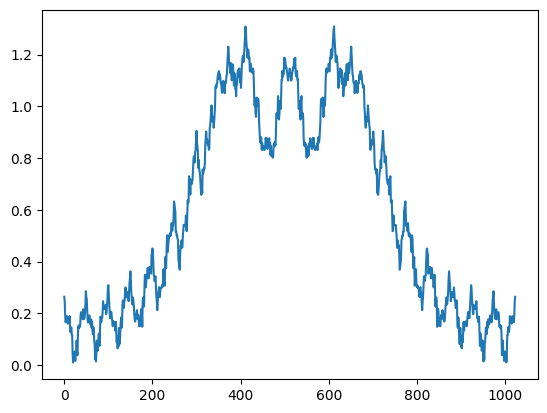

In [55]:
H_FR, g_z_AS = AS()
plt.plot(g_z_AS)
plt.show()

In [22]:
from numba import njit


@njit(parallel=True)
def numerical_integration(wave_length=1, n_S=50):
    wave_length = wave_length  # the length of the wave
    dx = 2 * wave_length  # the sampling interval
    N = 1024  #  the number of samplings
    S = 2048 * wave_length  # the size of the sampling window
    z = n_S * S  # the propagation distance

    # real = np.zeros(1024)
    # imag = np.zeros(1024)
    inte_result = np.zeros(1024)

    N = 4000

    g_src = np.zeros(N)
    g_src[int(N / 4) : int(N / 4 * 3)] = np.ones(int(N / 2))

    y_real = np.zeros(N)
    y_imag = np.zeros(N)
    x = np.zeros(N)

    d_x = S / N
    for k in range(0, N):
        x[k] = d_x * k

    d_x_dest = 2 * wave_length

    for x_dest_n in range(0, 1024):
        for k in range(0, N):
            r = math.sqrt(z**2 + (x_dest_n * d_x_dest - x[k]) ** 2)
            exp = cmath.exp(2j * math.pi * r / wave_length)
            # print(x_dest_n * d_x_dest - x[k])
            # print(r)
            # print(exp)
            fx = (
                g_src[k]
                * (exp / r)
                * (z / r)
                * (1 / (2 * math.pi * r) + 1 / (1j * wave_length))
            )
            y_real[k] = fx.real
            y_imag[k] = fx.imag
        inte_result[x_dest_n] = abs(
            np.sum(y_real*d_x) + np.sum(1j*y_imag*d_x)
        )
        # inte_result[x_dest_n] = abs(
        #     np.sum(np.multiply(fx, dx))
        # )
        # real[x_dest_n]=0.5*d_x*(2*np.sum(y_real)-y_real[0]-y_real[-1])
        # imag[x_dest_n]=0.5*d_x*(2*np.sum(y_imag)-y_imag[0]-y_imag[-1])

        inte_result_g = inte_result

    return inte_result_g

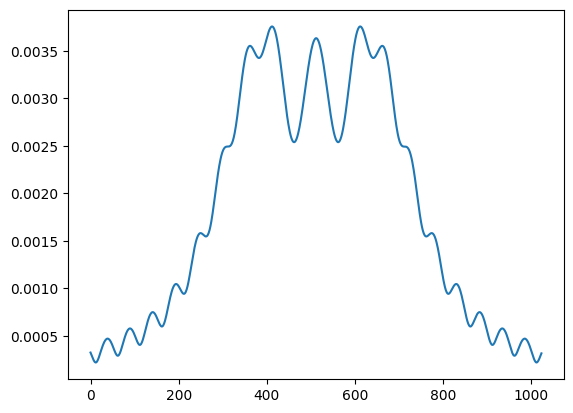

In [23]:
g_z = numerical_integration()
plt.plot(g_z)
plt.show()

## normalization with RMS

In [24]:
# attenuation_coefficient = AS_list/numerical_list
# diff = np.diff(attenuation_coefficient)
# plt.plot(attenuation_coefficient)
# plt.show()

# print(diff)


In [25]:
# def RMS(array1,array2):    
#     # rms1 = np.sqrt(np.mean(array1**2))
#     # rms2 = np.sqrt(np.mean(array2**2))
#     rms1 = np.std(array1)
#     rms2 = np.std(array2)
#     return rms1/rms2

In [26]:
# def RMS(array1,array2):    
#     # rms1 = np.sqrt(np.mean(array1**2))
#     # rms2 = np.sqrt(np.mean(array2**2))
#     rms1 = array1[512-1]+array1[512]
#     rms2 = array2[512-1]+array2[512]
#     return rms1/rms2

In [27]:
# def RMS(array1,array2):    
#     # rms1 = np.sqrt(np.mean(array1**2))
#     # rms2 = np.sqrt(np.mean(array2**2))
#     rms1 = np.mean(array1)
#     rms2 = np.mean(array2)
#     return rms1/rms2

In [28]:
def RMS(array1,array2):    
    # rms1 = np.sqrt(np.mean(np.square(array1[256:768])))
    # rms2 = np.sqrt(np.mean(np.square(array2[256:768])))
    rms1 = np.sqrt(np.mean(np.square(array1)))
    rms2 = np.sqrt(np.mean(np.square(array2)))
    return rms1/rms2

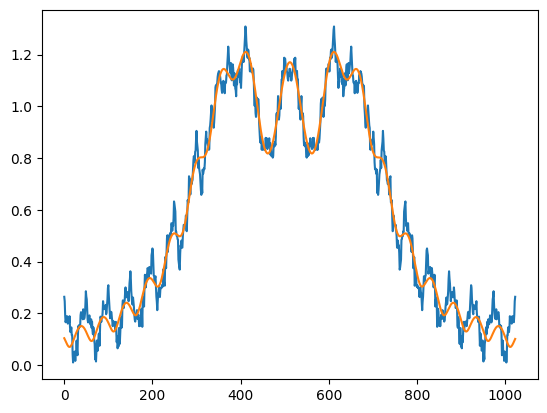

In [29]:
AS_spectrum, AS_result = AS(1, 50, -1)
numerical_result = numerical_integration(1, 50)
reference_field = RMS(AS_result, numerical_result) * numerical_result
plt.plot(AS_result)
plt.plot(reference_field)
plt.show()

## the SNR of AS method with different propogation distances

In [30]:
def SNR_cal(signal, noisy_signal):
    signal_power = np.mean(np.square(signal))
    noise_power = np.mean(np.square(noisy_signal - signal))
    snr_db = 10 * np.log10(signal_power / noise_power)
    return snr_db

In [31]:
SNR = []

n_S_list = list(np.linspace(-1, 2, 100))

for n_S in n_S_list:
    n_S = 10**n_S
    AS_spectrum, AS_result = AS(10000, n_S, -1)
    numerical_result = numerical_integration(10000, n_S)
    numerical_result_normalized = numerical_result * RMS(AS_result, numerical_result)
    SNR.append(SNR_cal(numerical_result_normalized,AS_result))

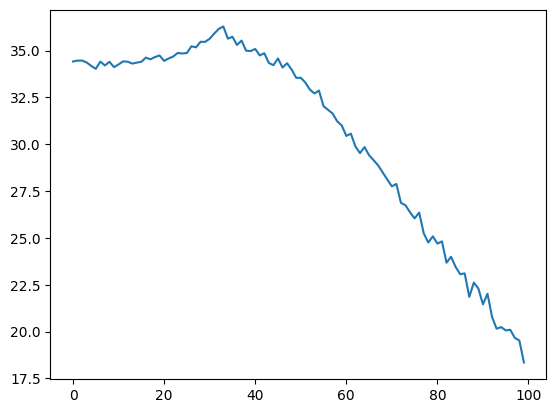

In [32]:
plt.plot(SNR)
# plt.xscale('log')
# plt.xticks([0.1, 1, 10, 100])
plt.show()

## comparison between AS and CV-FR

In [33]:
# def AS(wave_length=1, n_S=50, band_limit=-1):
#     wave_length = wave_length  # the length Fof the wave
#     dx = 2 * wave_length  # the sampling interval
#     N = 1024  #  the number of samplings
#     S = 2048 * wave_length  # the size of the sampling window
#     z = n_S * S  # the propagation distance

#     freq = np.fft.fftfreq(N, dx)
#     freq_square = freq**2
#     freq_squre_max = np.full(N, 1 / wave_length) ** 2
#     w_square_0 = freq_squre_max - freq_square
#     mask = w_square_0 > 0
#     w_square = np.where(mask, w_square_0, 0)

#     # the transfer function
#     H_FR = np.empty(N, dtype=complex)
#     # H_FR = np.exp(2j * math.pi * z * np.sqrt(w_square))
#     H_FR = np.exp(1j * math.pi * z * (2 / wave_length - wave_length * (freq_square)))

#     # generate the source plain spectrum
#     g_0 = np.zeros(N)
#     g_0[int(N / 4) : int(N / 4 * 3)] = np.ones(int(N / 2))
#     # g_0[int(N / 4) : int(N / 4 * 3)] = abs(
#     #     np.cos(np.linspace(-2 * math.pi, 2 * math.pi, int(N / 2)))
#     # )

#     G_0 = np.fft.fft(g_0)

#     # the dest plain spectrum
#     G_z = G_0 * H_FR

#     if band_limit == -1:
#         pass
#     else:
#         # limit the bandwidth
#         G_z = np.fft.fftshift(G_z)
#         f = band_limit
#         G_z[0 : 512 + 1 - f] = np.zeros(513 - f)
#         G_z[512 + f : 1024] = np.zeros(512 - f)
#         G_z = np.fft.ifftshift(G_z)

#     # the dest plain
#     g_z = abs(np.fft.ifft(G_z))

#     return G_z, g_z

In [34]:
# SNR1 = []
# for n_S in n_S_list:
#     n_S = 10**n_S
#     AS_spectrum, AS_result = AS(10000, n_S, -1)
#     numerical_result = numerical_integration(10000, n_S)
#     numerical_result_normalized = numerical_result * RMS(AS_result, numerical_result)
#     SNR1.append(SNR_cal(numerical_result_normalized,AS_result))

In [35]:
# SNR_2 = SNR
# SNR_1 = SNR1
# m=np.array(SNR_2)-np.array(SNR1)
# plt.plot(m)
# plt.show()

## improve the SNR by limiting the bandwidth

### implement of band_limited_AS

In [36]:
def band_limited_AS(wave_length, n_S):
    wave_length = wave_length  # the length Fof the wave
    dx = 2 * wave_length  # the sampling interval
    N = 1024  #  the number of samplings
    S = 2048 * wave_length  # the size of the sampling window
    z = n_S * S  # the propagation distance

    freq = np.fft.fftfreq(N, dx)
    freq = np.fft.fftshift(freq)

    d_u = 1 / (2 * S)
    u_limit = 1 / (np.sqrt((2 * d_u * z) ** 2 + 1) * wave_length)

    mask = abs(freq) <= u_limit
    if np.all(mask):
        clipper_n = -1
    else:
        first_true_index = np.argmax(mask)
        clipper_n = 513 - first_true_index

    H_FR_real, g_z = AS(1, n_S, clipper_n)
    print(clipper_n)
    return clipper_n, g_z

21


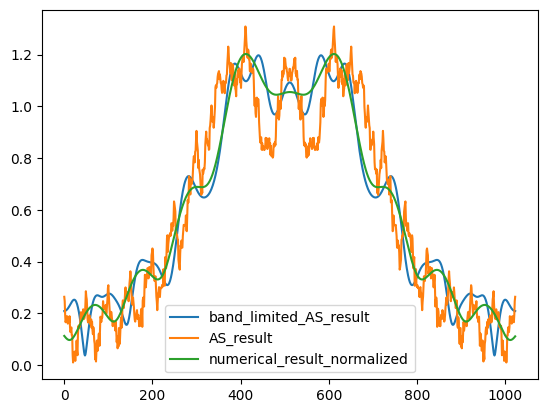

In [37]:
band_limited_AS_spectrum, band_limited_AS_result = band_limited_AS(1, n_S)
AS_spectrum, AS_result = AS(1, 50,-1)
numerical_result = numerical_integration(1, n_S)
numerical_result_normalized = numerical_result * RMS(AS_result, numerical_result)
plt.plot(band_limited_AS_result,label="band_limited_AS_result")
plt.plot(AS_result,label="AS_result")
plt.plot(numerical_result_normalized,label="numerical_result_normalized")

plt.legend()
plt.show()


### SNR of band-limited AS with different propogation distance

In [38]:
SNR_band_limited = []

n_S_list = list(np.linspace(-1, 2, 100))

for n_S in n_S_list:
    n_S = 10**n_S
    band_limited_AS_spectrum, band_limited_AS_result = band_limited_AS(1, n_S)
    AS_spectrum, AS_result = AS(1, 50,-1)
    numerical_result = numerical_integration(1, n_S)
    numerical_result_normalized = numerical_result * RMS(AS_result, numerical_result)
    SNR_band_limited.append(SNR_cal(numerical_result_normalized,band_limited_AS_result))

-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
-1
493
461
432
404
378
353
330
308
288
269
251
234
219
204
191
178
166
155
145
135
126
118
110
102
95
89
83
78
72
68
63
59
55
51
48
45
42
39
36
34
32
30
28
26
24
22
21


the print output above shows different clipper_n regarding to different distance z

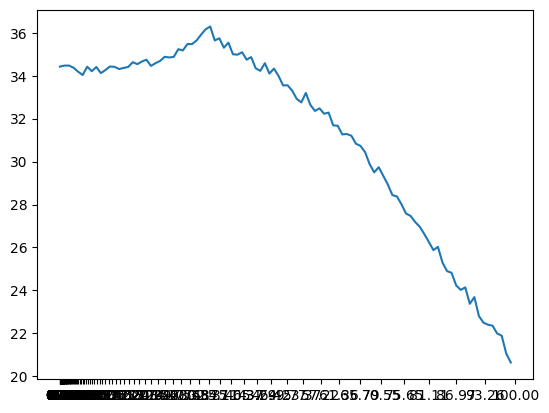

In [61]:
plt.plot(SNR_band_limited)
plt.xticks(10**np.array(n_S_list))
plt.show()

### the improvement from SNR_band_limited

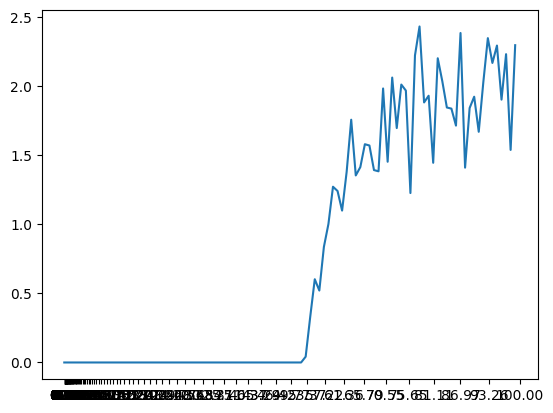

In [62]:
plt.plot(np.array(SNR_band_limited) - np.array(SNR))
plt.xticks(10**np.array(n_S_list))
plt.show()

### the clipper's effect on SNR

In [49]:
SNR_clipper = []

n_clipper_list = list(np.linspace(1, 100, 100))

for n_clipper in n_clipper_list:
    band_limited_AS_spectrum, band_limited_AS_result = AS(1, 50, int(n_clipper))
    numerical_result = numerical_integration(1, 50)
    numerical_result_normalized = numerical_result * RMS(
        band_limited_AS_result, numerical_result
    )
    SNR_clipper.append(SNR_cal(numerical_result_normalized, band_limited_AS_result))

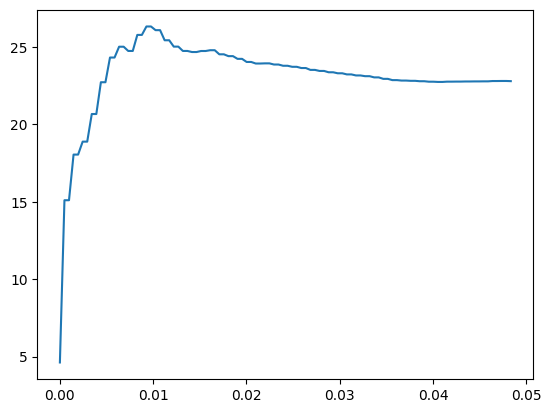

In [51]:
wave_length = 1
dx = 2 * wave_length  # the sampling interval
freq = np.fft.fftfreq(1024, dx)

plt.plot(freq[0:100],SNR_clipper)
plt.show()